# In this notebook, we'll make a dataset of syllable spectrograms
If your dataset is in the right format, this notebook shouldn't need any adjustments, beyond hyper parameters. 

After segmenting, we generate a JSON with new syllable segments. 

This might require a few GBs of RAM since we're loading the entire dataset. If your dataset is large or your computer doesn't have much RAM, you might want to break this down into batches, rewrite the code to memmap, etc. Let me know if you have issues here and we can try to figure out a solution.

In [1]:
from avgn.utils.hparams import HParams
from avgn.dataset import DataSet
import json

/mnt/cube/ntansey/avgn_test/avgn_paper/avgn/utils/general.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import noisereduce

In [3]:
DATASET_ID = 'koumura_bengalese_finch'

In [4]:
# create a set of hyperparameters for processing this dataset.  
hparams = HParams(
    num_mel_bins = 64,
    mel_lower_edge_hertz=500,
    mel_upper_edge_hertz=15000,
    butter_lowcut = 500,
    butter_highcut = 15000,
    ref_level_db = 20,
    min_level_db = -30,
    mask_spec = True,
    win_length_ms = 10,
    hop_length_ms = 2,
    nex=-1,
    n_jobs=-1,
    verbosity = 1,
)

### Create a dataset object
The dataset object loads JSONs corresponding to `DATASET_ID` in the data folder. 

In [5]:
# create a dataset object, which
dataset = DataSet(DATASET_ID, hparams = hparams)

loading json:   0%|          | 0/2964 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 669 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 2480 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 2964 out of 2964 | elapsed:    4.3s finished


getting unique individuals:   0%|          | 0/2964 [00:00<?, ?it/s]

2024-12-09 12:19:29.891363: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733775569.919083 3054023 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733775569.927271 3054023 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-09 12:19:33.787078: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-12-09 12:19:33.787139: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: txori.ucsd.edu
2024-12-09 12:19:33.787156: I external/local_xla/xla/st

In [6]:
# to make sure everything loaded correctly, lets look at a sample JSON
print(json.dumps(dataset.sample_json, indent=4, default=str)[:400] + '...')

{
    "species": "Lonchura striata domestica",
    "common_name": "Bengalese finch",
    "wav_loc": "/mnt/cube/ntansey/avgn_test/avgn_paper/data/raw/koumura/zip_contents/Bird8/Wave/135.wav",
    "samplerate_hz": 32000,
    "length_s": 6.453,
    "indvs": {
        "Bird8": {
            "notes": {
                "start_times": [
                    1.158,
                    1.309,
              ...


In [7]:
# how many wavs are in the dataset?
len(dataset.data_files)

2964

### Create a a pandas dataframe from the dataset
- We use joblib to parallelize the code, but all we're doing is grabbing the note start and stop times from the JSONs

In [8]:
from tqdm.autonotebook import tqdm
from avgn.signalprocessing.create_spectrogram_dataset import (
    prepare_wav,
    create_label_df,
    get_row_audio,
)
import pandas as pd
import numpy as np

In [9]:
from joblib import Parallel, delayed
n_jobs = -1; verbosity = 10

In [10]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllable_dfs = parallel(
        delayed(create_label_df)(
            dataset.data_files[key].data,
            hparams=dataset.hparams,
            labels_to_retain=['labels', 'sequence_num'],
            unit="notes",
            dict_features_to_retain = [],
            key = key,
        )
        for key in tqdm(dataset.data_files.keys())
    )
syllable_df = pd.concat(syllable_dfs)
len(syllable_df)

  0%|          | 0/2964 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.19263167727276587s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 125 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 169 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 193 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.15775561332702637s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done 243 tasks      | elap

214936

In [11]:
syllable_df[:3]

,start_time,end_time,labels,sequence_num,indv,indvi,key
0,1.158,1.244,0,0,Bird8,0,Bird8_135
1,1.309,1.461,0,0,Bird8,0,Bird8_135
2,1.529,1.669,0,0,Bird8,0,Bird8_135


### For each syllable, grab the corresponding audio
- Here we're looking through the wav files corresponding to the syllable, and grabbing the audio starting at `start_time` and ending at `end_time`

In [12]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllable_dfs = parallel(
        delayed(get_row_audio)(
            syllable_df[syllable_df.key == key], 
            dataset.data_files[key].data['wav_loc'], 
            dataset.hparams
        )
        for key in tqdm(syllable_df.key.unique())
    )
syllable_df = pd.concat(syllable_dfs)
len(syllable_df)

  0%|          | 0/2964 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 125 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 169 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 242 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 269 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 296 tasks      | elapsed:  

214936

In [13]:
# this is just getting rid of syllables that are zero seconds long, which be the product of errors in segmentation
df_mask  = np.array([len(i) > 0 for i in tqdm(syllable_df.audio.values)])
syllable_df = syllable_df[np.array(df_mask)]

  0%|          | 0/214936 [00:00<?, ?it/s]

In [14]:
syllable_df[:3]

,start_time,end_time,labels,sequence_num,indv,indvi,key,audio,rate
0,1.158,1.244,0,0,Bird8,0,Bird8_135,"[-0.0002731757, -0.0002551036, -0.00016501009,...",32000
1,1.309,1.461,0,0,Bird8,0,Bird8_135,"[0.0002468019, 0.00028092266, 0.00027472735, 0...",32000
2,1.529,1.669,0,0,Bird8,0,Bird8_135,"[3.2643315e-05, -0.0001274123, 0.00012728639, ...",32000


### Normalize the audio
- you can skip this step if you don't want to normalize the audio

In [15]:
import librosa

In [16]:
syllable_df['audio'] = [librosa.util.normalize(i) for i in syllable_df.audio.values]

In [17]:
import matplotlib.pyplot as plt

  0%|          | 0/50 [00:00<?, ?it/s]

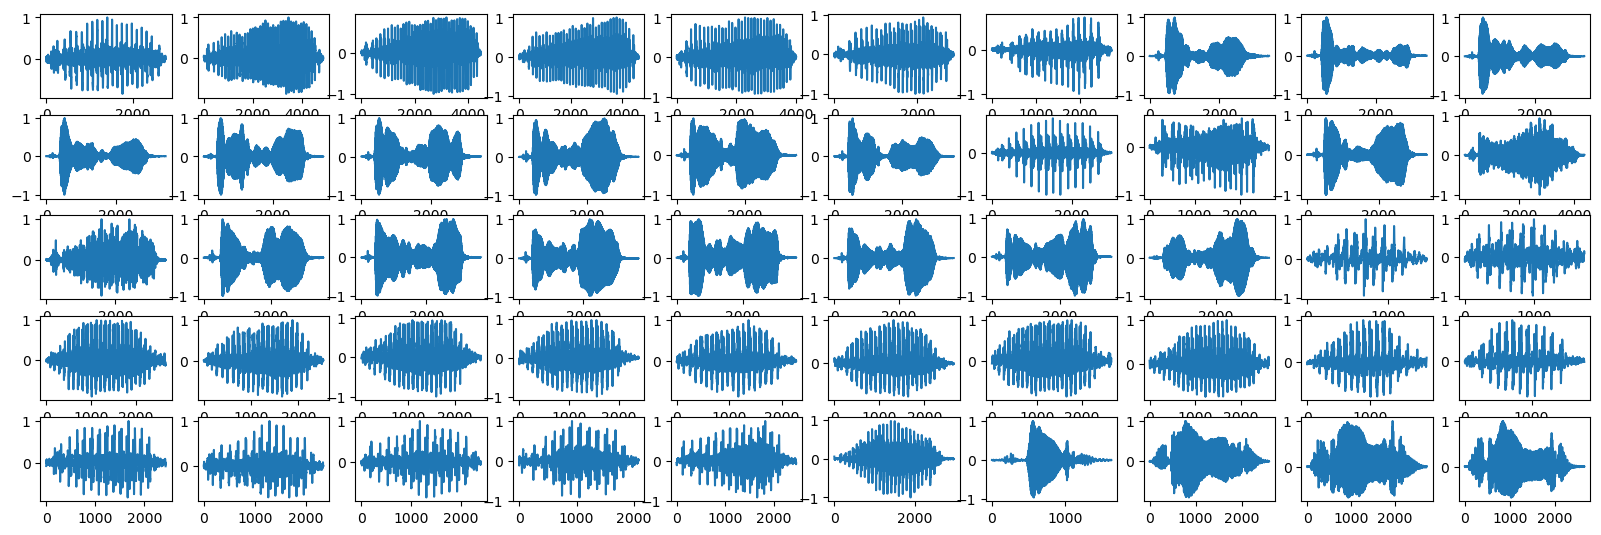

In [18]:
# plot some example audio 
nrows = 5
ncols = 10
zoom = 2
fig, axs = plt.subplots(ncols=ncols, nrows = nrows,figsize = (ncols*zoom, nrows+zoom/1.5))
for i, syll in tqdm(enumerate(syllable_df['audio'].values), total = nrows*ncols):
    ax = axs.flatten()[i]
    ax.plot(syll)
    if i == nrows*ncols -1:
        break

### Create spectrograms of each syllable

In [19]:
from avgn.signalprocessing.create_spectrogram_dataset import make_spec

In [20]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    # create spectrograms
    syllables_spec = parallel(
        delayed(make_spec)(
            syllable,
            rate,
            hparams=dataset.hparams,
            mel_matrix=dataset.mel_matrix,
            use_mel=True,
            use_tensorflow=False,
        )
        for syllable, rate in tqdm(
            zip(syllable_df.audio.values, syllable_df.rate.values),
            total=len(syllable_df),
            desc="getting syllable spectrograms",
            leave=False,
        )
    )

getting syllable spectrograms:   0%|          | 0/214936 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.016109704971313477s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.10949254035949707s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 198 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 244 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 292 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Batch computation too fas

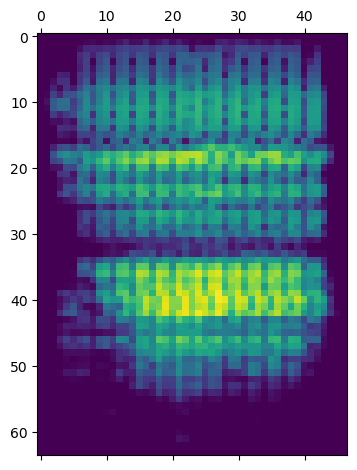

In [21]:
# plot an example syllable
plt.matshow(syllables_spec[16])

### Rescale spectrogram
This is another optional step. It is to log rescale the length of your syllable spectrogram. It is useful when there is a wide distribution of syllable lengths (e.g. 2 seconds and 0.25 seconds). 

In [22]:
from avgn.signalprocessing.create_spectrogram_dataset import log_resize_spec

In [23]:
# hyperparameter, where larger = higher dimensional spectrogram
log_scaling_factor = 10

In [24]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllables_spec = parallel(
        delayed(log_resize_spec)(spec, scaling_factor=log_scaling_factor)
        for spec in tqdm(syllables_spec, desc="scaling spectrograms", leave=False)
    )

scaling spectrograms:   0%|          | 0/214936 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.012224912643432617s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  85 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.177903413772583s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.08465099334716797s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 244 tasks      | elapsed:    0.3s
[Parallel(n_jobs

In [25]:
from avgn.visualization.spectrogram import draw_spec_set

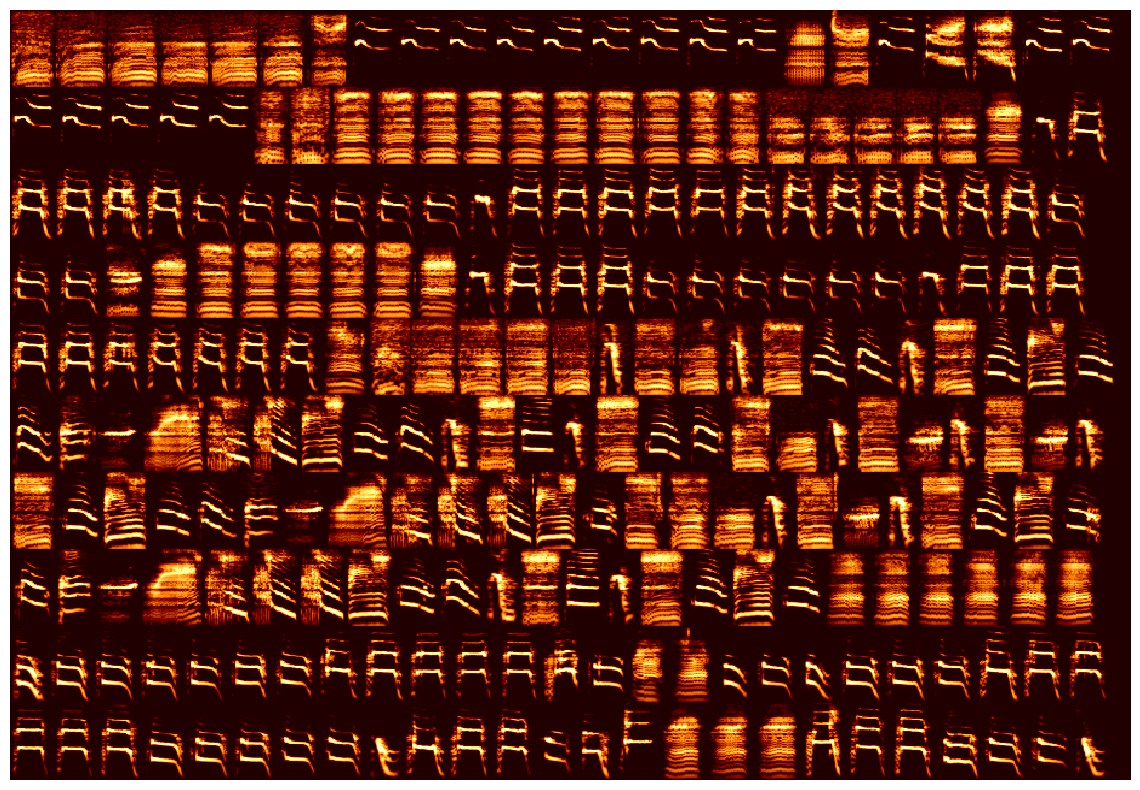

In [26]:
# lets take a look at these spectrograms
draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=25)

In [27]:
# (optional) normalize the spectrograms into uint8, to make the dataset smaller
def norm(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))
syllables_spec = [(norm(i)*255).astype('uint8') for i in tqdm(syllables_spec)]

  0%|          | 0/214936 [00:00<?, ?it/s]

### Pad spectrograms so each syllable is the same # of dimensions
First, lets look at the distribution of syllable lengths to see how much padding needs to be done. 

In [28]:
# lets look at the 
import seaborn as sns

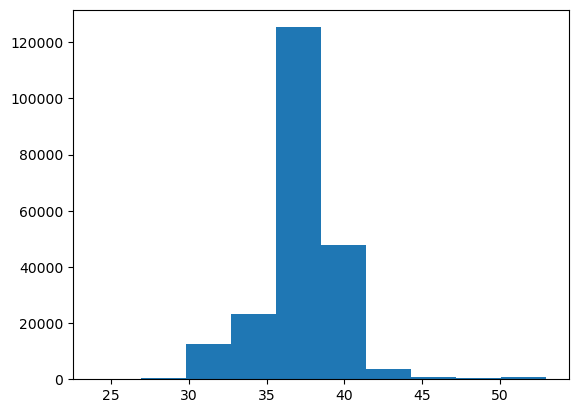

In [29]:
syll_lens = [np.shape(i)[1] for i in syllables_spec]
plt.hist(syll_lens);

In [30]:
from avgn.signalprocessing.create_spectrogram_dataset import pad_spectrogram

In [31]:
pad_length = np.max(syll_lens)

In [32]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:

    syllables_spec = parallel(
        delayed(pad_spectrogram)(spec, pad_length)
        for spec in tqdm(
            syllables_spec, desc="padding spectrograms", leave=False
        )
    )

padding spectrograms:   0%|          | 0/214936 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.017042160034179688s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  87 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.05685997009277344s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done 117 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 159 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07244491577148438s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 248 tasks      | elapsed:    0.3s
[Parallel(n_jo

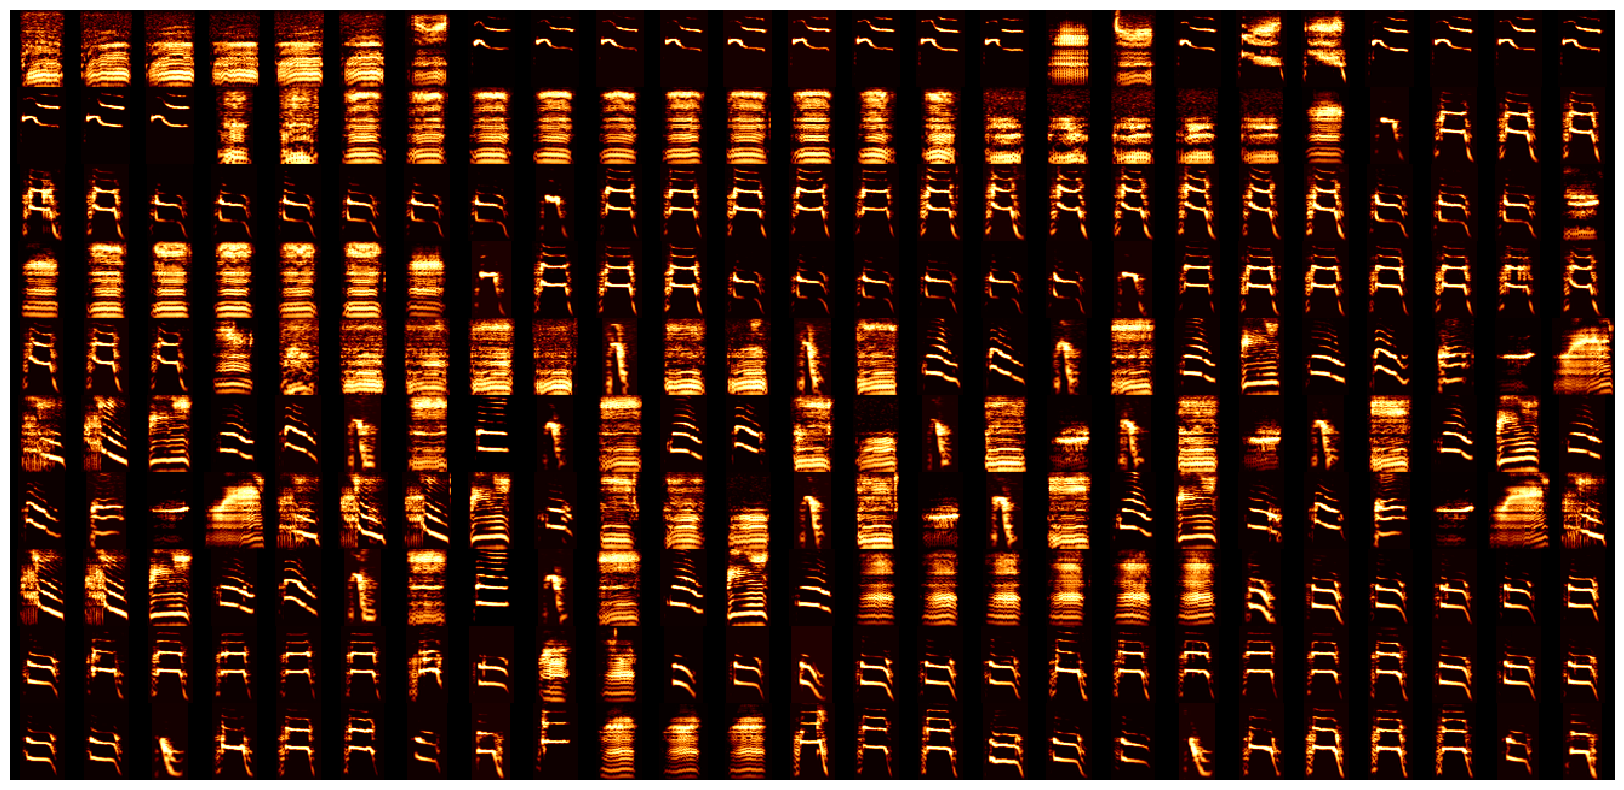

In [33]:
draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=25)

In [34]:
# what is the dimensionality of the dataset
print(np.shape(syllables_spec))

(214936, 64, 53)


In [35]:
# convert to uint8 to save space
syllables_spec = [(norm(i)*255).astype('uint8') for i in tqdm(syllables_spec)]

  0%|          | 0/214936 [00:00<?, ?it/s]

In [36]:
syllable_df['spectrogram'] = syllables_spec

In [37]:
syllable_df[:3]

,start_time,end_time,labels,sequence_num,indv,indvi,key,audio,rate,spectrogram
0,1.158,1.244,0,0,Bird8,0,Bird8_135,"[-0.058588706, -0.05471273, -0.035390142, 0.03...",32000,"[[0, 0, 0, 0, 0, 0, 0, 0, 4, 7, 32, 58, 65, 70..."
1,1.309,1.461,0,0,Bird8,0,Bird8_135,"[0.037415795, 0.042588584, 0.04164936, 0.04476...",32000,"[[0, 0, 0, 0, 0, 4, 4, 4, 4, 8, 44, 33, 29, 46..."
2,1.529,1.669,0,0,Bird8,0,Bird8_135,"[0.0044432213, -0.017342634, 0.017325494, 0.03...",32000,"[[0, 0, 0, 0, 0, 8, 9, 9, 11, 39, 41, 30, 27, ..."


### Save the datasset
That's it. Now we can save that dataset of syllables, and use it for whatever downstream analyses we're interested in. 

At this point, it's worth looking at the other notebooks in the repo, and trying out those methods (e.g. UMAP projections, clustering, neural network projections, etc).

In [38]:
from avgn.utils.paths import DATA_DIR, ensure_dir

In [39]:
save_loc = DATA_DIR / 'example_bengalese_finch_dataset.pickle'
ensure_dir(save_loc)
# we'll save without the audio (optional)
syllable_df.drop('audio', axis = 1).to_pickle(save_loc)

In [40]:
syllable_df

,start_time,end_time,labels,sequence_num,indv,indvi,key,audio,rate,spectrogram
0,1.158,1.244,0,0,Bird8,0,Bird8_135,"[-0.058588706, -0.05471273, -0.035390142, 0.03...",32000,"[[0, 0, 0, 0, 0, 0, 0, 0, 4, 7, 32, 58, 65, 70..."
1,1.309,1.461,0,0,Bird8,0,Bird8_135,"[0.037415795, 0.042588584, 0.04164936, 0.04476...",32000,"[[0, 0, 0, 0, 0, 4, 4, 4, 4, 8, 44, 33, 29, 46..."
2,1.529,1.669,0,0,Bird8,0,Bird8_135,"[0.0044432213, -0.017342634, 0.017325494, 0.03...",32000,"[[0, 0, 0, 0, 0, 8, 9, 9, 11, 39, 41, 30, 27, ..."
3,1.736,1.881,0,0,Bird8,0,Bird8_135,"[0.03057456, -0.0053426493, -0.030420339, 0.01...",32000,"[[0, 0, 0, 0, 0, 5, 5, 4, 10, 15, 7, 10, 10, 9..."
4,1.937,2.062,0,0,Bird8,0,Bird8_135,"[-0.016228981, 0.02908936, 0.0443059, 0.012854...",32000,"[[0, 0, 0, 0, 0, 0, 7, 11, 7, 12, 30, 26, 44, ..."
...,...,...,...,...,...,...,...,...,...,...
102,16.944,17.020,4,6,Bird7,0,Bird7_170,"[0.0012591981, 0.0026807145, 0.0010486143, 0.0...",32000,"[[0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3,..."
103,17.086,17.176,0,6,Bird7,0,Bird7_170,"[0.009218068, 0.0015370512, 0.000918475, 0.009...",32000,"[[0, 0, 0, 0, 0, 0, 0, 6, 5, 9, 8, 6, 6, 9, 9,..."
104,17.249,17.334,1,6,Bird7,0,Bird7_170,"[0.0012503368, -0.005089342, -0.0064551714, -0...",32000,"[[0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9,..."
105,17.368,17.451,5,6,Bird7,0,Bird7_170,"[-0.0019514738, -0.0010694988, 0.0025579098, -...",32000,"[[0, 0, 0, 0, 0, 0, 0, 0, 6, 6, 6, 6, 4, 22, 5..."
